In [18]:
import sys
import math
import time
from pathlib import Path
from typing import Callable, Tuple

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction

state_dir = Path("state_vectors")


data_dir = Path("measurements")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")

Running on: cpu


In [19]:
def compute_mz_abs(samples: torch.Tensor) -> float:
    # convert spins into +1/-1 domain, take absolute mean per sample then batch
    spins_pm = 1.0 - 2.0 * samples.float()
    mz_per_sample = spins_pm.mean(dim=1)
    mz_abs = mz_per_sample.abs()
    return mz_abs.mean().item()

def compute_mx(samples: torch.Tensor, log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> float:
    B, N = samples.shape
    with torch.no_grad():
        log_scores_orig = log_score_fn(samples)
        total_ratios = torch.zeros(B, device=samples.device, dtype=torch.float32)

        for i in range(N):
            flipped = samples.clone()
            flipped[:, i] = 1 - flipped[:, i]
            log_scores_flip = log_score_fn(flipped)
            total_ratios += torch.exp(log_scores_flip - log_scores_orig)

        avg_mx_per_sample = total_ratios / N
        return avg_mx_per_sample.mean().item()

In [20]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000
TRAIN_SAMPLE_COUNT = 20_000

h_support = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
h_novel_int = []
h_novel_fill = [1.50, 1.80, 2.20, 2.40, 2.60, 2.80, 3.20, 3.40, 3.60, 3.80, 4.20, 4.50, 5.50, 6.50]
h_novel = sorted(h_novel_int + h_novel_fill)

sweep = sorted([(h, "support") for h in h_support] + [(h, "novel") for h in h_novel], key=lambda x: x[0])

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

print(f"Support points: {h_support}")
print(f"Training on {TRAIN_SAMPLE_COUNT} samples per support point.")

samples_per_support = [TRAIN_SAMPLE_COUNT] * len(file_paths)
dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], samples_per_support)

Support points: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Training on 20000 samples per support point.


In [23]:
N_EPOCHS = 10
BATCH_SIZE = 1024
NUM_HIDDEN = 64
HYPER_NET_WIDTH = 64
K_STEPS = 10
GIBBS_NOISE_FRAC = 0.1
INIT_LR = 1e-2
FINAL_LR = 1e-4

# --- Multi-model setup ---
SEEDS = list(range(42, 43))  # 10 models; change as you like

# --- Eval setup ---
SAMPLES_EVAL = 10_000
K_STEPS_EVAL = 10
schedule_tensor = torch.tensor([1.0] * K_STEPS_EVAL, device=device, dtype=torch.float32)

print(f"Training {len(SEEDS)} models in parallel and evaluating magnetizations on {len(sweep)} h values...")

def train_and_eval_one_seed(seed: int) -> pd.DataFrame:
    # Important: avoid CPU thread oversubscription when running multiple processes
    torch.set_num_threads(1)

    seed = int(seed)
    print(f"\n=== Seed {seed} ===")

    torch.manual_seed(seed)
    rng_train = torch.Generator().manual_seed(seed)

    loader = MeasurementLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
        rng=rng_train
    )

    model = SymmetricHyperRBM(
        num_v=dataset.num_qubits,
        num_h=NUM_HIDDEN,
        hyper_dim=HYPER_NET_WIDTH,
        k=K_STEPS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    scheduler = get_sigmoid_curve(INIT_LR, FINAL_LR, N_EPOCHS * len(loader), 0.005)

    model = train_loop(
        model,
        optimizer,
        loader,
        num_epochs=N_EPOCHS,
        lr_schedule_fn=scheduler,
        noise_frac=GIBBS_NOISE_FRAC,
        rng=rng_train
    )

    # deterministic eval RNG per seed
    rng_eval = torch.Generator(device=device).manual_seed(seed + 123456)

    rows = []
    for h_val, kind in sweep:
        cond_batch = torch.full((SAMPLES_EVAL, 1), h_val, device=device, dtype=torch.float32)
        samples = model.generate(cond_batch, T_schedule=schedule_tensor, rng=rng_eval)

        scorer = lambda v, cb=cond_batch: model.log_score(v, cb)

        mz = compute_mz_abs(samples)
        mx = compute_mx(samples, scorer)

        rows.append({"seed": seed, "h": float(h_val), "type": kind, "mz": float(mz), "mx": float(mx)})

    return pd.DataFrame(rows)

# n_jobs=-1 uses all cores; set to a fixed number if you want to be gentle on the machine
seed_dfs = Parallel(n_jobs=-1, backend="loky")(
    delayed(train_and_eval_one_seed)(s) for s in SEEDS
)

magnet_seed_df = pd.concat(seed_dfs, ignore_index=True).sort_values(["h", "seed"])
magnet_seed_df

Training 1 models in parallel and evaluating magnetizations on 21 h values...


KeyboardInterrupt: 

In [14]:
# Error bars from model-to-model variation (across seeds)
g = magnet_seed_df.groupby(["h", "type"], as_index=False)

mean_df = g[["mz", "mx"]].mean().rename(columns={"mz": "mz_mean", "mx": "mx_mean"})
std_df  = g[["mz", "mx"]].std(ddof=1).rename(columns={"mz": "mz_err", "mx": "mx_err"})

magnet_err_df = mean_df.merge(std_df, on=["h", "type"]).sort_values("h")

print("Aggregated (mean ± std over seeds):")
magnet_err_df.head()

Aggregated (mean ± std over seeds):


,h,type,mz_mean,mx_mean,mz_err,mx_err
0,1.0,support,0.968558,0.248360,0.000381,0.001694
1,1.5,novel,0.929068,0.368418,0.001602,0.004031
2,1.8,novel,0.886508,0.459611,0.002750,0.005566
3,2.0,support,0.842505,0.533649,0.003093,0.005974
4,2.2,novel,0.785780,0.610680,0.002177,0.004597


Loaded ED reference data from: tfim_4x4_magnet_ref.csv



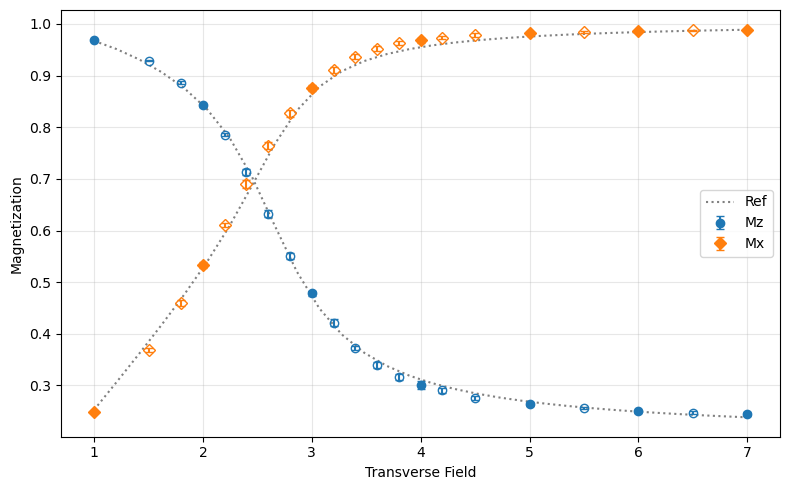

In [15]:
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_ref.csv")
ref_df = pd.read_csv(ref_file)
print(f"Loaded ED reference data from: {ref_file.name}\n")

support_df = magnet_err_df[magnet_err_df["type"] == "support"]
novel_df = magnet_err_df[magnet_err_df["type"] == "novel"]

plt.figure(figsize=(8, 5), dpi=100)

# Reference curves
plt.plot(ref_df["h"], ref_df["mag_z"], ":", color="gray", label="Ref")
plt.plot(ref_df["h"], ref_df["mag_x"], ":", color="gray")

# |Mz| with error bars
plt.errorbar(
    support_df["h"], support_df["mz_mean"], yerr=support_df["mz_err"],
    fmt="o", color="tab:blue", capsize=3, label="Mz"
)
plt.errorbar(
    novel_df["h"], novel_df["mz_mean"], yerr=novel_df["mz_err"],
    fmt="o", color="tab:blue", mfc="none", capsize=3
)

# Mx with error bars
plt.errorbar(
    support_df["h"], support_df["mx_mean"], yerr=support_df["mx_err"],
    fmt="D", color="tab:orange", capsize=3, label="Mx"
)
plt.errorbar(
    novel_df["h"], novel_df["mx_mean"], yerr=novel_df["mx_err"],
    fmt="D", color="tab:orange", mfc="none", capsize=3
)

plt.xlabel("Transverse Field")
plt.ylabel("Magnetization")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()